In [1]:
import os
os.environ["JAX_CACHE_DIR"] = "/cluster/scratch/mpundir/jax-cache"
os.environ["PLOT_LIB_PATH"] = "/cluster/home/mpundir/dev"

import jax

jax.config.update("jax_compilation_cache_dir", os.environ["JAX_CACHE_DIR"])
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")

import numpy as np

In [2]:
from spectralsolvers.operators import spatial, tensor, fourier_galerkin
from spectralsolvers.fft.transform import _fft, _ifft
from spectralsolvers.solvers.linear import conjugate_gradient_while
from spectralsolvers.solvers.nonlinear import newton_krylov_solver

from functools import partial

from skimage.morphology import disk, rectangle, ellipse
import equinox as eqx
from typing import Callable

import sys  
sys.path.append(os.environ["PLOT_LIB_PATH"])
from plottwist.decorators import plot, subplots, imshow, imshow_grid, STYLE_PATH
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt

In this notebook, we implement the small-strain `J2` plasticity. We use the automatic differentiation to compute the alogriothmic tangent stiffness matrix (which ia function of bbothe elastic strain and plastic strain and yield function). It is necessary for `Newton-Raphson` iteration. 

## constructing an RVE

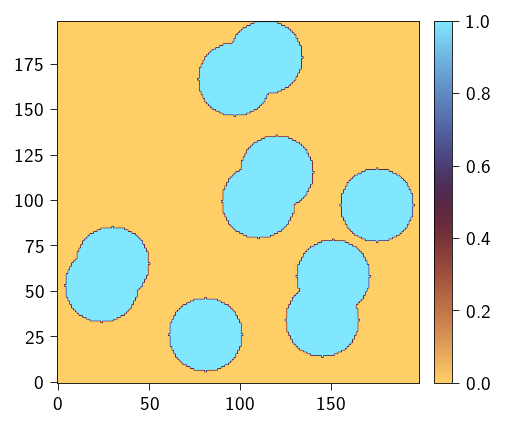

In [76]:
import random
random.seed(1)

def place_circle(matrix, n, r, x_center, y_center):
    for i in range(n):
        for j in range(n):
            if (i - x_center)**2 + (j - y_center)**2 <= r**2:
                matrix[i][j] = 1

@imshow(cmap=cmc.managua, enable=True)
def generate_matrix_with_circles(n, x, r):
    if r >= n:
        raise ValueError("Radius r must be less than the size of the matrix n")
        
    matrix = np.zeros((n, n), dtype=int)
    placed_circles = 0
    
    while placed_circles < x:
        x_center = random.randint(0, n-1)
        y_center = random.randint(0, n-1)
        
        # Check if the circle fits within the matrix bounds
        if x_center + r < n and y_center + r < n and x_center - r >= 0 and y_center - r >= 0:
            previous_matrix = matrix.copy()
            place_circle(matrix, n, r, x_center, y_center)
            if not np.array_equal(previous_matrix, matrix):
                placed_circles += 1

    return matrix

# Example usage
N = 199
shape = (N, N)
length = 1.
ndim = 2

grid_size = (N,) * ndim
elasticity_dof_shape = (ndim, ndim) + grid_size

x = 10
r = 20
structure = generate_matrix_with_circles(N, x, r)

## assigning material parameters 
We assign material parameters to the two phases. The two phases within the RVE are denoted as
- Soft = 0
- Hard = 1

In [77]:
# material parameters + function to convert to grid of scalars
@partial(jax.jit, static_argnames=["soft", "hard"])
def param(X, soft, hard):
    return hard * jnp.ones_like(X) * (X) + soft * jnp.ones_like(X) * (1 - X)

We consider a `linear isotropic hardening law` for both the phases

In [78]:
# material parameters
phase_constrast = 2

K = param(structure, soft=0.833, hard= phase_constrast*0.833)  # bulk      modulus
μ = param(structure, soft=0.386, hard= phase_constrast*0.386)  # shear     modulus
H = param(
    structure, soft=2000.0e6 / 200.0e9, hard=phase_constrast* 2000.0e6 / 200.0e9
)  # hardening modulus
sigma_y = param(
    structure, soft=600.0e6 / 200.0e9, hard=phase_constrast * 600.0e6 / 200.0e9
)  # initial yield stress

n = 1.

## plasticity basics

Now we define the basics of plasticity implementation:
- yield surface
  $$\Phi(\sigma_{ij}, \varepsilon^p_{ij}) = \underbrace{\sqrt{\dfrac{3}{2}\sigma^{dev}_{ij}\sigma^{dev}_{jk}}}_{\sigma^{eq}} - (\sigma_{0} + H\varepsilon^{p})$$
- return mappping algorithm
  $$\Delta \varepsilon =  \dfrac{\langle \Phi(\sigma_{ij}, \varepsilon_{p}) \rangle_{+}}{3\mu + H}$$
- tangent stiffness operator
  $$\mathbb{C} = \dfrac{\partial \sigma^{t+1}}{\partial \varepsilon^{t+1}} $$

We also define certain Identity tensor for each grid point.

- $\mathbf{I}$ = 2 order Identity tensor with shape `(2, 2, N, N)` 
- $\mathbb{I4}$ = 4 order Identity tensor with shape `(2, 2, 2, 2, N, N)`


In [79]:
# identity tensor (single tensor)
i = jnp.eye(ndim)

# identity tensors (grid)
I = jnp.einsum(
    "ij,xy",
    i,
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)  # 2nd order Identity tensor
I4 = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("il,jk", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)  # 4th order Identity tensor
I4rt = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("ik,jl", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)
I4s = (I4 + I4rt) / 2.0

II = tensor.dyad22(I, I)
I4d = I4s - II / 3.0

In [80]:
@jax.jit
def yield_function(ep : jnp.ndarray):
    return sigma_y + H*ep**n

@jax.jit
def sigma(eps : jnp.ndarray, args : tuple):

    eps_t, epse_t, ep_t = args

    # elastic stiffness tensor
    C4e = K * II + 2.0 * μ * I4d

    # trial state
    epse_s = epse_t + (eps - eps_t)
    sig_s = tensor.ddot42(C4e, epse_s)
    sigm_s = tensor.ddot22(sig_s, I) / 3.0
    sigd_s = sig_s - sigm_s * I
    sigeq_s = jnp.sqrt(3.0 / 2.0 * tensor.ddot22(sigd_s, sigd_s))

    # avoid zero division below ("phi_s" is corrected below)
    Z = jnp.where(sigeq_s == 0, True, False)
    sigeq_s = jnp.where(Z == True, 1, sigeq_s)

    # evaluate yield surface, set to zero if elastic (or stress-free)
    sigy = yield_function(ep_t)
    phi_s = sigeq_s - sigy
    phi_s = 1.0 / 2.0 * (phi_s + jnp.abs(phi_s))
    phi_s = jnp.where(Z == True, 0.0, phi_s)
    elastic_pt = jnp.where(phi_s <= 0, True, False)

    # plastic multiplier, based on non-linear hardening
    # - initialize
    dep = phi_s / (3 * μ + H)

    # return map algorithm
    N = 3.0 / 2.0 * sigd_s / sigeq_s
    ep = ep_t + dep
    sig = sig_s - dep * N * 2.0 * μ
    epse = epse_s - dep * N
    #jax.debug.print('x = {}', sig_s)
    
    return sig, epse, ep


@eqx.filter_jit
def compute_tangents(deps : jnp.ndarray, additionals : tuple, sigma : Callable):
    deps = deps.reshape(ndim,ndim,N,N)
    eps, eps_t, epse_t, ep_t = additionals
    tangents = jax.jvp(partial(sigma, args=(eps_t, epse_t, ep_t)), (eps,), (deps,))[1]
    return tangents[0]

partial_compute_tangent = partial(compute_tangents, sigma=sigma)


In [75]:
class J2PlasticityOperator(eqx.Module):
    Ghat: jnp.ndarray
    funcs: dict[str, Callable]
    elasticity_dof_shape: tuple[int, ...]

    def __init__(
        self,
        N,
        ndim,
        length,
        compute_stress,
        compute_tangent,
        gradient_operator=spatial.Operator.rotated_difference,
    ):
        self.Ghat = fourier_galerkin.compute_projection_operator_legacy(
            grid_size=(N,) * ndim, operator=gradient_operator, length=length
        )
        self.funcs = {}
        self.funcs["fft"] = jax.jit(partial(_fft, N=N, ndim=ndim))
        self.funcs["ifft"] = jax.jit(partial(_ifft, N=N, ndim=ndim))
        self.funcs["compute_tangent"] = compute_tangent
        self.funcs["compute_stress"] = compute_stress
        self.elasticity_dof_shape = (ndim, ndim) + (N,) * ndim


    def __call__(self, deps, args=None):
        deps = deps.reshape(self.elasticity_dof_shape)
        dsigma = self.funcs["compute_tangent"](deps, args)
        return jnp.real(
            self.funcs["ifft"](tensor.ddot42(self.Ghat, self.funcs["fft"](dsigma)))
        ).reshape(-1)

    def residual(self, eps : jnp.ndarray, args=None):
        sigma = self.funcs["compute_stress"](eps, args)[0]
        return jnp.real(
            self.funcs["ifft"](tensor.ddot42(self.Ghat, self.funcs["fft"](sigma)))
        ).reshape(-1)
    


j2_plasticity_op = J2PlasticityOperator(
    N,
    ndim,
    length,
    gradient_operator=spatial.Operator.rotated_difference,
    compute_tangent=partial_compute_tangent,
    compute_stress=sigma,
)

## solution algorithm 

For Newton-Raphson iterations, 
\begin{align}
0 &= f(x) = f(x_0 + \Delta x) \\
  &= f(x_0) +  \underbrace{\dfrac{\partial f(x_0)}{\partial x} \Delta x}_{\Delta f} + O(|\Delta x|^2)
\end{align}

We compute directly the $\Delta f$ by using the `Jacobian-vector product`. Since are `sigma` function depends on various quantities, we make it a partial function and only evalute it for  $\Delta  \varepsilon$.
\begin{align}
 \Delta \sigma = \dfrac{\partial \sigma( \varepsilon, \varepsilon^{t}, \varepsilon_e^t, \varepsilon_p^t)}{\partial \varepsilon} \Delta \varepsilon
\end{align}

In [91]:
@jax.jit
def solve_plasticity(state, n):
    deps, b, eps, eps_t, epse_t, ep_t, En, sig= state

    error = jnp.linalg.norm(deps) / En
    jax.debug.print("residual={}", error)

    def true_fun(state):
        deps, b, eps, eps_t, epse_t, ep_t, En, sig = state

        deps, iiter = conjugate_gradient_while(
            atol=1e-6,
            A=j2_plasticity_op, 
            b=b,
            additionals= (eps, eps_t, epse_t, ep_t),
        )  # solve linear system using CG

        deps = deps.reshape(ndim, ndim, N, N)
        eps = jax.lax.add(eps, deps)  # update DOFs (array -> tensor.grid)
        sig, epse, ep = sigma(eps, (eps_t, epse_t, ep_t))
        b = -j2_plasticity_op.residual(eps, (eps_t, epse_t, ep_t))  # compute residual

        jax.debug.print('CG iteration {}', iiter)

        return (deps, b, eps, eps_t, epse, ep, En, sig)

    def false_fun(state):
        return state

    return jax.lax.cond(error > 1e-5, true_fun, false_fun, state), n

In [92]:
# initialize: stress and strain tensor, and history
sig = jnp.zeros(elasticity_dof_shape)
eps = jnp.zeros(elasticity_dof_shape)
eps_t = jnp.zeros(elasticity_dof_shape)
epse_t = jnp.zeros(elasticity_dof_shape)
ep_t = jnp.zeros([N, N])

# define incremental macroscopic strain
ninc = 100
epsbar = 0.12
deps = jnp.zeros(elasticity_dof_shape)
deps = deps.at[0, 0].set(jnp.sqrt(3.0) / 2.0 * epsbar / float(ninc))
deps = deps.at[1, 1].set(-jnp.sqrt(3.0) / 2.0 * epsbar / float(ninc))

b = -j2_plasticity_op(deps, (eps, eps_t, epse_t, ep_t))
eps = jax.lax.add(eps, deps)
En = jnp.linalg.norm(eps)


# plot results

In [96]:
state = (deps, b, eps, eps_t, epse_t, ep_t, En, sig)
final_state, xs = jax.lax.scan(solve_plasticity, init=state, xs=jnp.arange(0, 10))


residual=1.0
CG iteration 13
residual=0.3034751005914213
CG iteration 0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0


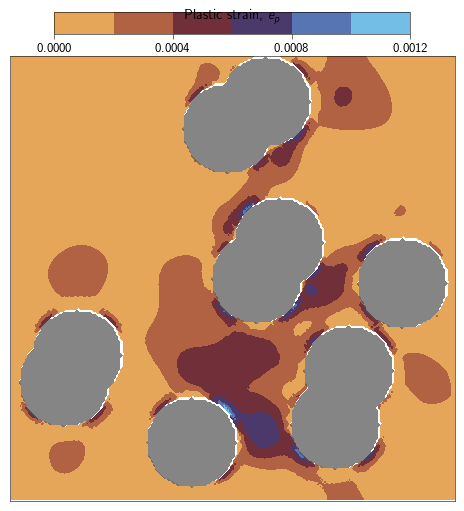

In [107]:
import matplotlib.ticker as ticker

quantity = np.ma.array(final_state[5], mask=structure)
vmin = np.min(quantity)
vmax = np.max(quantity)
        
plt.style.use(STYLE_PATH)
fig = plt.figure( figsize=(6, 5), constrained_layout=True, dpi=100)
ax = plt.axes()
ax.contourf(np.ma.array(structure[:, :], mask=1-structure), alpha=0.7,  cmap='Greys_r', zorder=30)
title=r'$\mathrm{Plastic~strain,}~e_p$'
quantity = np.ma.array(final_state[5], mask=structure)
vmin = np.min(quantity)
vmax = np.max(quantity)
        
cs = ax.contourf(quantity, origin='lower', cmap=cmc.managua,  levels=6 )
cs2 = ax.contour(quantity, origin='lower', colors='k', levels=6, linestyles='dashdot',  linewidths=0.0001, alpha=0  )#, vmin=vmin, vmax=vmax, zorder=1, levels=8)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

axins1 = ax.inset_axes([0.1, 1.05, 0.8, 0.05])

cbar = fig.colorbar(cs, cax=axins1, pad=0.05, 
                      fraction=0.025, shrink=.5, orientation="horizontal")
tick_locator = ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label(title, fontsize=10, labelpad=-32, y=0.85)
cbar.ax.yaxis.set_offset_position('right')  


ax.set_aspect(1/ax.get_data_ratio())
plt.show()